# Минипроект
## Автор: Кац Лев

<div style="text-align: right"> <em>В телескоп на Солнце можно посмотреть всего два раза в жизни.
Правым и левым глазом...</em> </div>

## Введение
В этом проекте мы попробуем исследовать активность Солнца. Обычно для этих целей исторически использовали значения площади пятен на солнце или числа Вольфа, которые также зависят от количества пятен и их площади. Пятно на солнце &mdash; некоторая область с меньшей температурой и потому темнее. Почему пятна? Вообще говоря расположение пятен определенным образом характеризует магнитное поле, что в свою очередь и связано с активностью.

<img width = '800px' src="images/sun.jpg">

## Наш датасет. Первичный анализ данных и предобработка.
Нам повезло, с 1874 года астрономы смотрели на солнце и получали нужные нам числа. Позже это собрали здесь https://solarscience.msfc.nasa.gov/greenwch.shtml.
В папке data расположен распокованный архив с файлами по годам.
Что в строке файла? Полное описание есть вот здесь https://solarscience.msfc.nasa.gov/greenwch/format.txt. Естественно, несколько разных групп занимались этими наблюдениями, поэтому у данных довольно разный формат местами и этот формат менялся в определенные годы. Также есть пропущенные значения. 
Отсюда мы извлечем дату, площадь пятна, расстояние от центра солнца, угол от направления на север.
Это соотвественно позиции 1-8, 41-44, 46-50, 52-56. Почему именно эти числа? Ну, все остальные значения представлены в сильно разных форматах и в определенные периоды могли не измеряться. Ну и менялась классификация.

### Получим некоторую таблицу из всех файлов

In [1]:
from os import listdir
from os.path import isfile, join
import re
import pandas as pd

In [2]:
def list_of_files(path):
    return [join(path, f) for f in listdir(path) if isfile(join(path, f))]

In [3]:
time_pattern = re.compile(r"(.{4,4})(.{2,2})(.{2,2})")

In [4]:
def process_line(line):
    return {
        'time': pd.Timestamp(
            *map(int, re.search(time_pattern, line[:8:]).groups()), 12, 0
        ),
        'squere': float(line[40:44:]),
        'dist': float(line[45:50:]),
        'angle': float(line[51:56:])
    }

In [5]:
from tqdm import tqdm

In [6]:
def process_file(filename):
    with open(filename, "r") as file:
        return pd.DataFrame(map(process_line, file))


df = pd.DataFrame()
for filename in tqdm(list_of_files("data/")):
    df = df.append(process_file(filename), ignore_index=True)

100%|██████████| 140/140 [00:02<00:00, 49.57it/s]


In [7]:
df = df.sort_values(by="time")

In [8]:
df.head(10)

,time,squere,dist,angle
124636,1874-05-01 12:00:00,0.0,0.000,0.0
124637,1874-05-02 12:00:00,0.0,0.000,0.0
124638,1874-05-03 12:00:00,0.0,0.000,0.0
124639,1874-05-04 12:00:00,0.0,0.000,0.0
124640,1874-05-05 12:00:00,0.0,0.000,0.0
124641,1874-05-06 12:00:00,0.0,0.000,0.0
124642,1874-05-07 12:00:00,0.0,0.000,0.0
124643,1874-05-08 12:00:00,0.0,0.000,0.0
124646,1874-05-09 12:00:00,68.0,0.783,299.3
124645,1874-05-09 12:00:00,852.0,0.733,96.8


In [9]:
df.describe()

,squere,dist,angle
count,241520.000000,241520.000000,241520.000000
mean,160.736018,0.634372,181.107168
std,264.847897,0.251577,97.872319
min,0.000000,0.000000,0.000000
25%,20.000000,0.430000,90.200000
50%,68.000000,0.652000,187.600000
75%,190.000000,0.864000,272.700000
max,6132.000000,1.000000,359.900000


### Получим по дням таблицу со значением суммарной площади

In [10]:
temp = {}
for row in map(lambda i: df.iloc[i], range(df.shape[0])):
    temp.setdefault(row["time"], 0.0) 
    temp[row["time"]] += row["squere"]

squere = pd.DataFrame(map(lambda key: {
    "time": key,
    "sum_squere": temp[key]
}, temp))

Да, бывают алгоритмы и побыстрее. Но я мог пить чай эти две минуты.

In [11]:
squere.describe()

,sum_squere
count,43523.000000
mean,891.964318
std,961.973787
min,0.000000
25%,193.000000
50%,583.000000
75%,1267.000000
max,8382.000000


### Наша цель

Итак, мы хотим получить некоторые предсказания временного ряда относительно суммарной площади пятен, исследовать сезонность (и возможно открыть заново 11 и 22 летние циклы солнечной активности). Также попробуем сравнить "запятненность" на разных широтах (например, на севере или на юге), есть ли какая-то разница и какие-то особенности в распределении по площади. Почему именно широты? Ну, это связано уже с движением пятен по диску солнца вдоль параллелей. И просто вращением солнца.

## Визуальный анализ данных

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

### Смотрим на ременной ряд

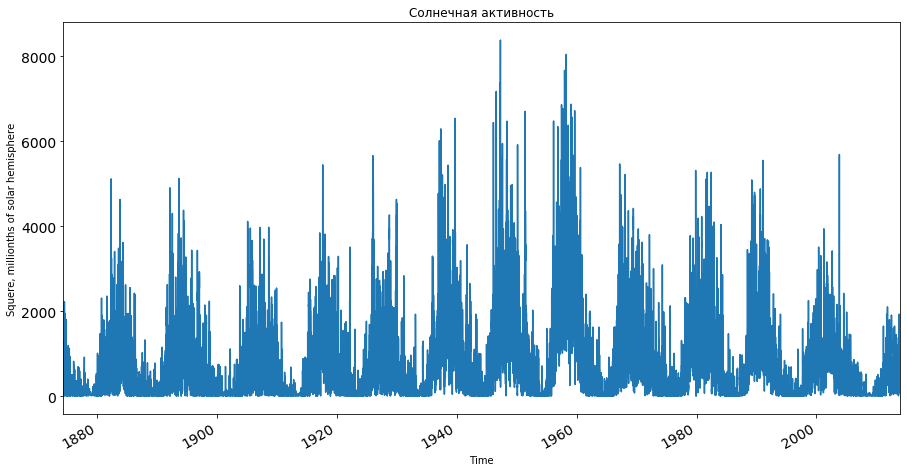

In [13]:
squere[['time','sum_squere']].plot('time', figsize=(15,8), title='Солнечная активность', fontsize=14, legend=False)
plt.ylabel("Squere, millionths of solar hemisphere")
plt.xlabel("Time")
plt.show()

Выглядит немного не очень. Давайте еще попробуем приблизить последние лет 50

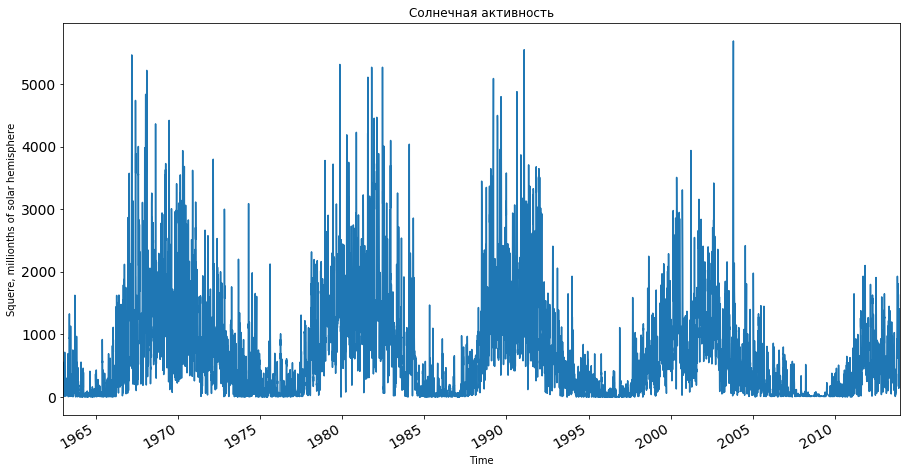

In [14]:
squere[['time','sum_squere']][squere.time >= pd.Timestamp(1963, 1, 1)].plot(
    'time', figsize=(15,8), title='Солнечная активность', fontsize=14, legend=False
)
plt.ylabel("Squere, millionths of solar hemisphere")
plt.xlabel("Time")
plt.show()

Вообще наблюдается определенная сезонность с периодом около 10 лет, не так ли?

### Смотрим на пятна

Разделим пятна на северные и южные

Почему мы вообще можем так делать? В смысле просто брать выборки пятен из разных дней и средние брать за период? Позже мы покажем, что ряд **стационарен**

In [15]:
north_df = df[(df.angle < 90.0) | (df.angle >= 270.0)]
temp = {}
for row in map(lambda i: north_df.iloc[i], range(north_df.shape[0])):
    temp.setdefault(row["time"], 0.0) 
    temp[row["time"]] += row["squere"]

south = pd.DataFrame(map(lambda key: {
    "time": key,
    "sum_squere": temp[key]
}, temp))

south_df = df[(df.angle >= 90.0) & (df.angle < 270.0)]
temp = {}
for row in map(lambda i: south_df.iloc[i], range(south_df.shape[0])):
    temp.setdefault(row["time"], 0.0) 
    temp[row["time"]] += row["squere"]

north = pd.DataFrame(map(lambda key: {
    "time": key,
    "sum_squere": temp[key]
}, temp))

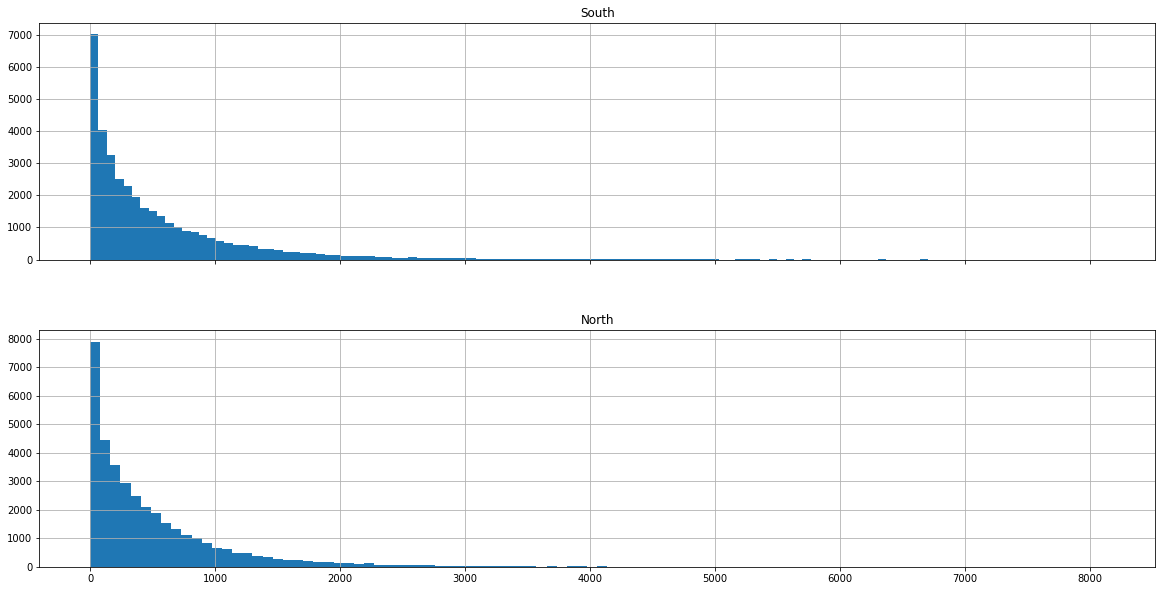

In [16]:
f, (ax1, ax2) = plt.subplots(
    nrows=2, sharex=True, figsize=(20, 10)
)
south.hist(column='sum_squere', bins=100, ax=ax1)
north.hist(column="sum_squere", bins=100, ax=ax2)
ax1.set_title("South")
ax2.set_title("North")
plt.show()

Весьма занятная форма распределений вообще говоря. Хотя внешне похожи. Радует

Попробуем построить средние, чтобы пользоваться в будущем в том числе параметрическими критериями

In [17]:
import numpy as np

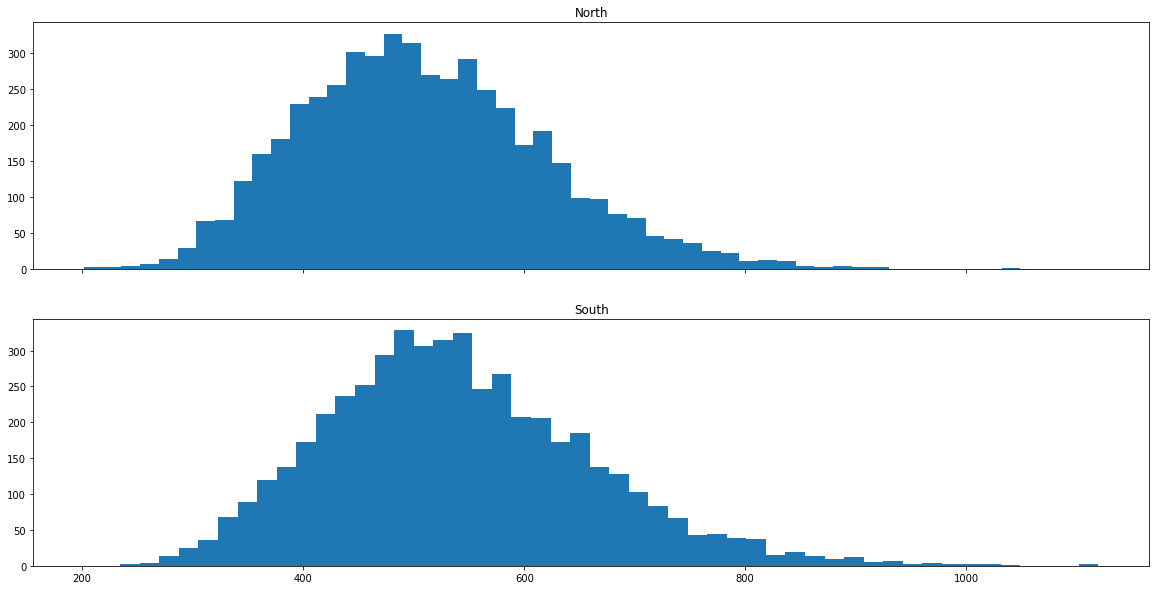

In [18]:
f, (ax1, ax2) = plt.subplots(
    nrows=2, sharex=True, figsize=(20, 10)
)
n = 30
north_means = [np.mean(np.random.choice(north.sum_squere, n)) for _ in range(5000)]
ax1.hist(north_means, bins=50)
ax1.set_title("North")
south_means = [np.mean(np.random.choice(south.sum_squere, n)) for _ in range(5000)]
ax2.hist(south_means, bins=50)
ax2.set_title("South")
plt.show()

## Проверка статистических гипотез

### Запятненность севера и юга из одного распределения?

H0: площадь пятен на севере и на юге принадлежат одному распределению

H1: площадь пятен на севере и на юге принадлежат разным распределениям

Ну, это два множества объектов. Кажется, уместно применить критерий Стьюдента для несвязанных выборок
Хотя на всякий случай давайте проверим распределения на нормальность. ЦПТ, конечно, никто не отменял, но может быть я где-то был не прав

In [19]:
from scipy import stats

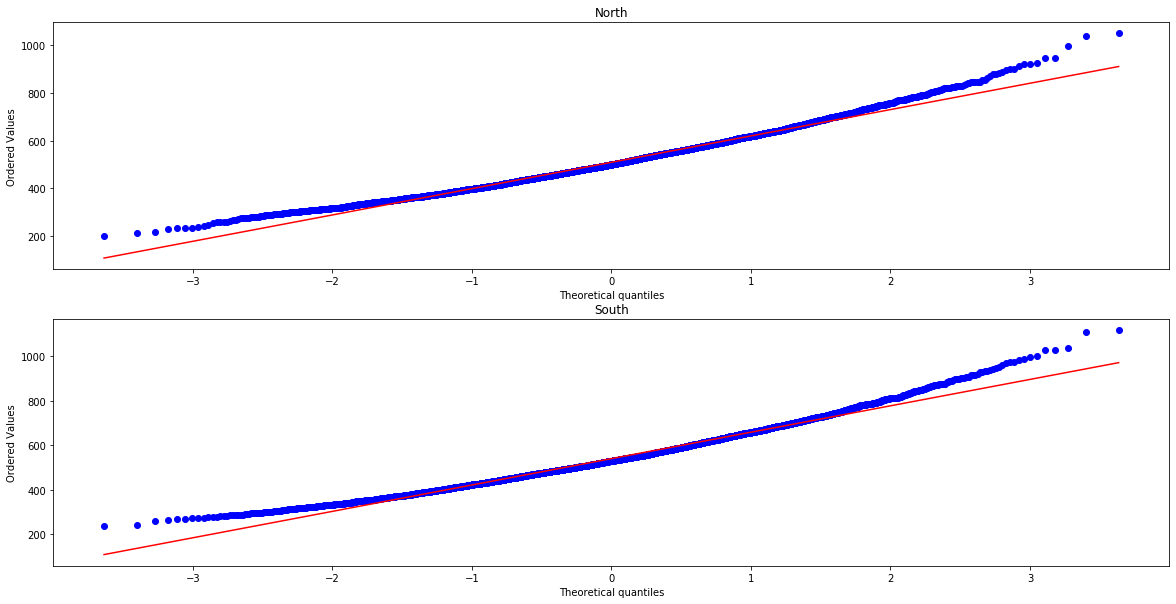

In [20]:
f, (ax1, ax2) = plt.subplots(
    nrows=2, figsize=(20, 10)
)
stats.probplot(north_means, dist="norm", plot=ax1)
ax1.set_title("North")
stats.probplot(south_means, dist="norm", plot=ax2)
ax2.set_title("South")
plt.show()

In [21]:
t_stat = stats.ttest_ind(north_means, south_means)
t_stat

Ttest_indResult(statistic=-13.12889190552378, pvalue=4.7284572147477536e-39)

Очень интересно! Действительно разные распределения! H0 отвергнута

In [22]:
import statsmodels.stats.api as sms
cm = sms.CompareMeans(sms.DescrStatsW(north_means), sms.DescrStatsW(south_means))
print (cm.tconfint_diff())

(-34.84649556312572, -25.792784436874378)


То есть с 95% вероятностью средняя площадь на севере отличается от средней площади на юге на 25-34 миллонных диска солнца, что вполне ощутимо с нашей точностью измерений

Теперь давайте попробуем проделать нечто похожее **непараметрически** и уже не для средних. Для этого можно использовать Критерий Манна-Уитни

In [23]:
stats.mannwhitneyu(south.sum_squere, north.sum_squere, alternative='greater')

MannwhitneyuResult(statistic=689571534.5, pvalue=0.0007209159505037176)

Ну, опять же нулевая гипотеза отвергается

## Анализ временного ряда

In [24]:
import statsmodels.api as sm
from pylab import rcParams

In [25]:
rcParams['figure.figsize'] = 12, 7
squere.index  = squere.time
squere.drop('time', axis=1, inplace=True)
squere.head(10)

,sum_squere
time,
1874-05-01 12:00:00,0.0
1874-05-02 12:00:00,0.0
1874-05-03 12:00:00,0.0
1874-05-04 12:00:00,0.0
1874-05-05 12:00:00,0.0
1874-05-06 12:00:00,0.0
1874-05-07 12:00:00,0.0
1874-05-08 12:00:00,0.0
1874-05-09 12:00:00,1298.0


Ожидаем периодичнось в 11 лет

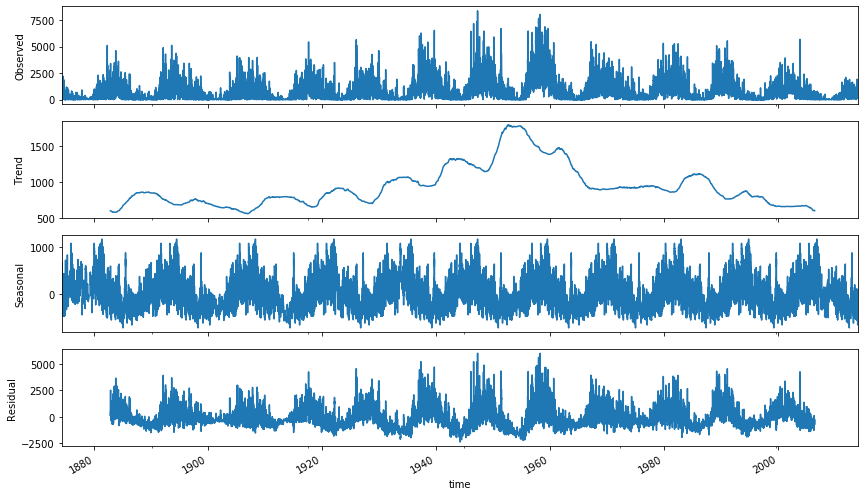

In [26]:
rcParams['figure.figsize'] = 12, 7
result = sm.tsa.seasonal_decompose(squere, model='additive', freq=int(365.25*11))
result.plot()
plt.show()

Надо сказать, плохо получилось

In [27]:
from statsmodels.tsa.api import ExponentialSmoothing

In [28]:
train = squere.iloc[:-365]
test = squere.iloc[-365:]

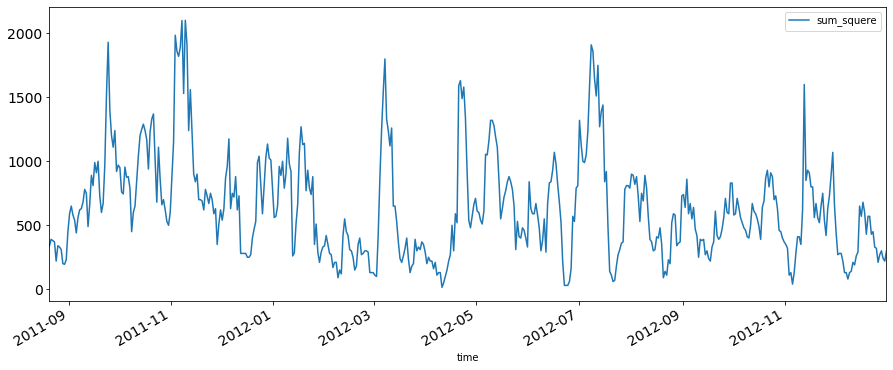

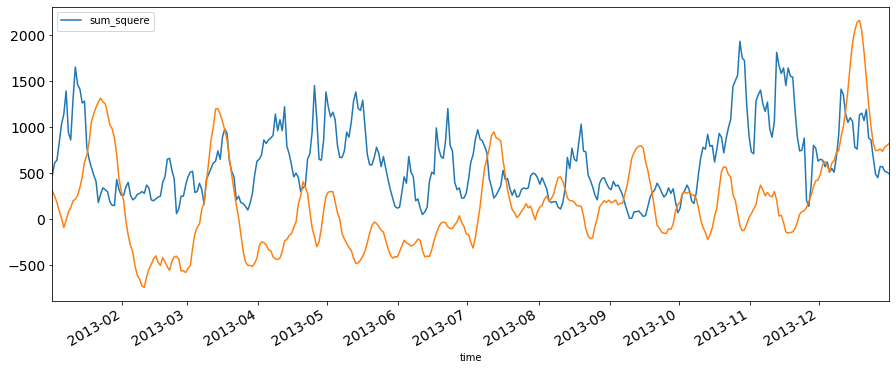

In [29]:
train.iloc[-500:].plot(figsize=(15,6), fontsize=14)
test.plot(figsize=(15,6), fontsize=14)
forecast = test.copy()

fit1 = ExponentialSmoothing(np.asarray(train), seasonal_periods=365, trend='add', seasonal='add').fit()
forecast = pd.Series(fit1.forecast(len(test)))
forecast.index = test.index
forecast.plot(figsize=(15,6), fontsize=14)
plt.show()

В общем плохо! Надо будет попробовать какой-то другой подход...

In [30]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries, window = 24, cutoff = 0.05):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries.values,autolag='AIC' )
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    pvalue = dftest[1]
    if pvalue < cutoff:
        print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
    
    print(dfoutput)

In [31]:
sample_data = squere[-10000:].sum_squere

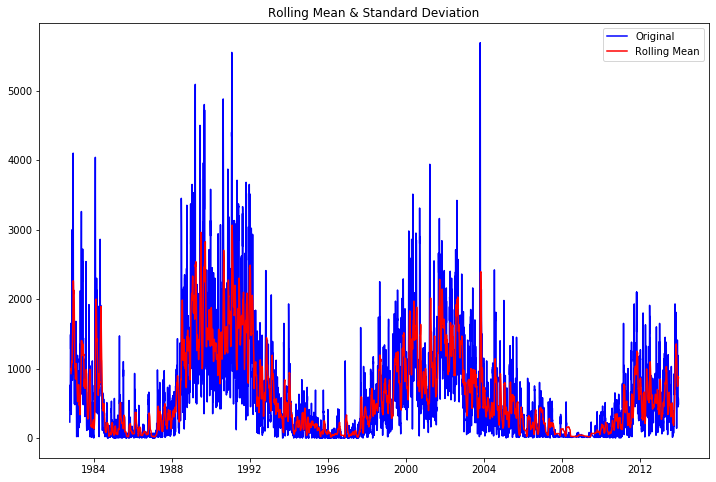

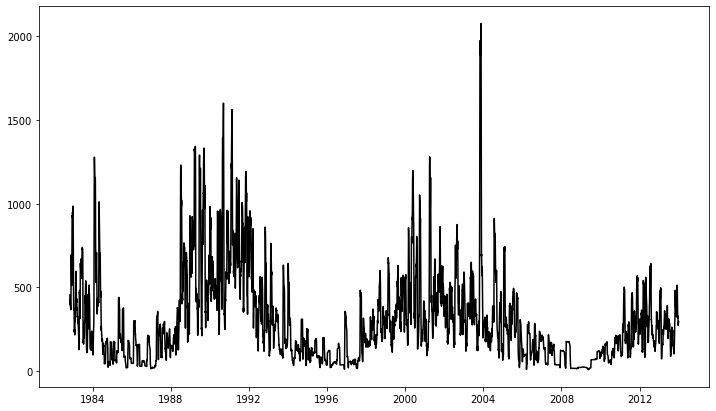

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                -6.426159e+00
p-value                        1.742492e-08
#Lags Used                     3.800000e+01
Number of Observations Used    9.961000e+03
Critical Value (1%)           -3.431007e+00
Critical Value (5%)           -2.861830e+00
Critical Value (10%)          -2.566924e+00
dtype: float64


In [32]:
test_stationarity(sample_data)

Зато хоть ряд стационарный :)

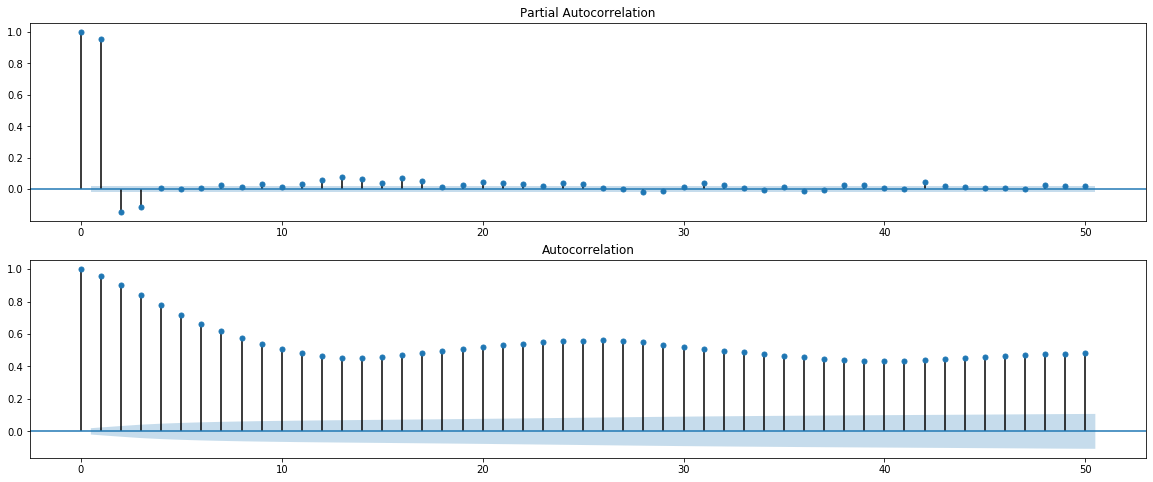

In [33]:
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(20,8))
sm.graphics.tsa.plot_pacf(sample_data, lags=50, ax=ax1)
sm.graphics.tsa.plot_acf(sample_data, lags=50, ax=ax2)
plt.show()

Попробуем взять первую разность все-таки, mак как на графике частной автокорреляционной функции заметно выделяется только один лаг

In [34]:
first_dif = sample_data - sample_data.shift(1)

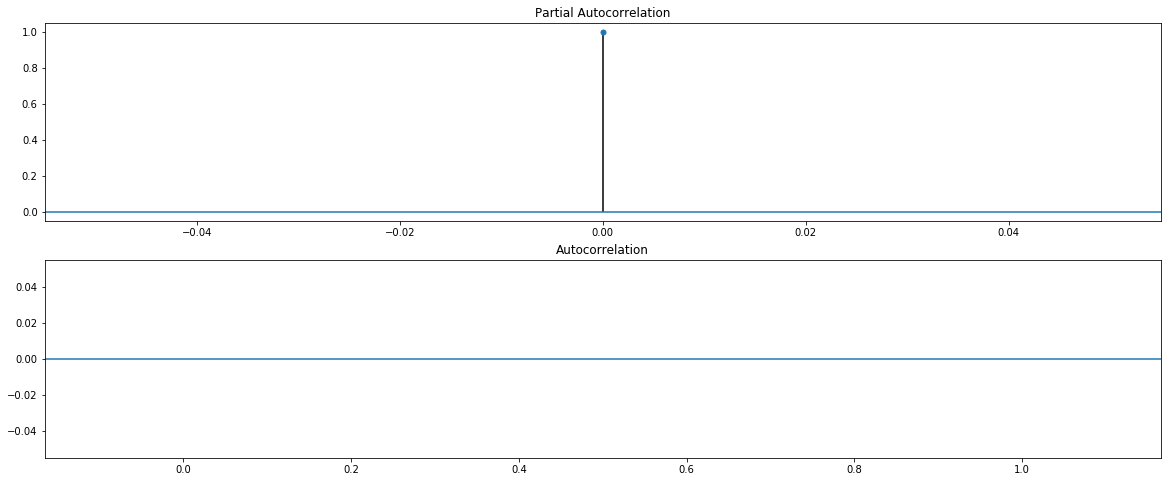

In [35]:
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(20,8))
sm.graphics.tsa.plot_pacf(first_dif, lags=50, ax=ax1)
sm.graphics.tsa.plot_acf(first_dif, lags=50, ax=ax2)
plt.show()

То есть мы не учитывали сезонность и взяли только первую разность.

In [36]:
s = 365 * 11

ps = range(0, 2)
d=1
qs = range(0, 2)
Ps = range(0, 2)
D=0
Qs = range(0, 2)

In [37]:
from itertools import product

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

16

In [38]:
%%time
import warnings
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(sample_data, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

CPU times: user 1min 26s, sys: 55.2 s, total: 2min 21s
Wall time: 39.2 s


In [39]:
print(best_model.summary().tables[0])
print(best_model.summary().tables[1])

                                 Statespace Model Results                                 
Dep. Variable:                         sum_squere   No. Observations:                10000
Model:             SARIMAX(1, 1, 1)x(1, 0, 0, 12)   Log Likelihood              -67844.631
Date:                            Wed, 04 Dec 2019   AIC                         135697.263
Time:                                    17:22:40   BIC                         135726.104
Sample:                                         0   HQIC                        135707.025
                                          - 10000                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3792      0.048      7.964      0.000       0.286       0.473
ma.L1         -0.2715      0.049   

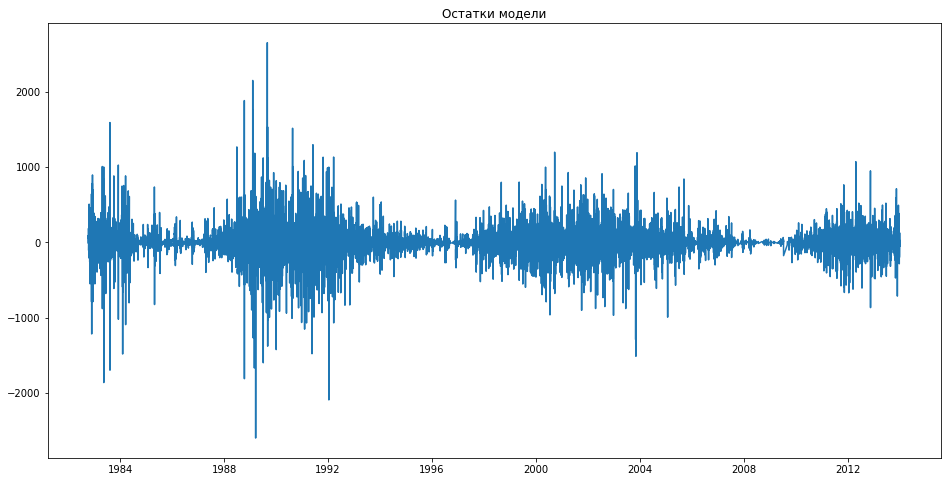

In [40]:
plt.figure(figsize=(16,8))
plt.title("Остатки модели")
plt.plot(best_model.resid[1:])
plt.show()

Я бы сказал, довольно плохой белый шум... Что-то в нем есть от голосового сообщения

In [41]:
stat_test = sm.tsa.adfuller(best_model.resid[:])
print ('adf: ', stat_test[0] )
print ('p-value: ', stat_test[1])
print('Critical values: ', stat_test[4])
if stat_test[0]> stat_test[4]['5%']: 
    print ('есть единичные корни, ряд не стационарен')
else:
    print ('единичных корней нет, ряд стационарен')

adf:  -22.817130125177258
p-value:  0.0
Critical values:  {'1%': -3.4310066595695945, '5%': -2.861830204343065, '10%': -2.5669244706354584}
единичных корней нет, ряд стационарен


In [42]:
forecast = best_model.predict(start=sample_data.shape[0], end=sample_data.shape[0]+365)

/home/lev/Sphere/IntroductionToDataAnalysisAndDataMining/spherePy/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


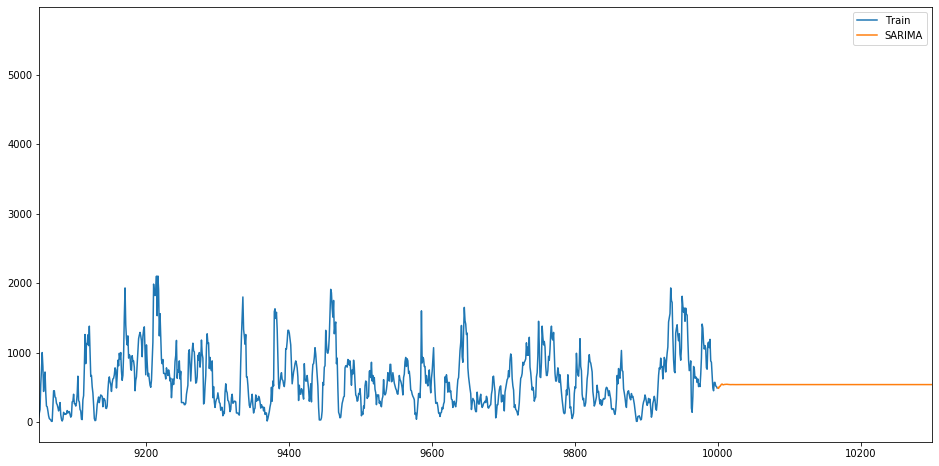

In [43]:
plt.figure(figsize=(16,8))
plt.plot(np.array(sample_data), label='Train')
plt.plot(forecast, label='SARIMA')
plt.legend(loc='best')
plt.xlim(9050, 10300)
plt.show()

Такое себе предсказание. Ну, в каком-то смысле, конечно, завтра это вчера

## Вывод

Мы изучили временной ряд и распределение пятен по поверхности Солнца. Каких-то внятных предсказаний для ряда добиться не удалось, но зато выяснилось,
что в среднем на юге больше пятен. Да и просто больше. Почему? Ну, возможно, какие-то спорные случаи вблизи экватора не совсем знают как классифицировать
и относят в южную часть? Или наоборот это вблизи полюсов, и мы не видим какие-то участки?